Task 1 is to complete the below skeleton code to play a Pac-Man-esque game in 3D. You are allowed to utilise the deep learning method discussed in the course. It is designed to test multiple components of the module syllabus, including 3D geometry, object detection and image manipulation.

The aim of the coursework is to step through a 3D pointcloud of the mysterious PhD lab. Several large spheres have been placed within the space, it is your job to move through the pointcloud in an automated fashion, detecting the location of the sphere and moving to the predicted 3D location. If you land close enough to a sphere it will be captured and removed from the pointcloud. 

You will need to design deep neural networks to detect the spheres within an image. You can then use the helper function provided in the PacMan_Helper.py module to obtain the XYZ coordinates of the pixel you predict to be a sphere.


## Imports
Here we will do our usual imports. I would recommend numpy, scipy, skimage, sklearn, pytorch, and matplotlib. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_Helper module as well.

In [1]:
import PacMan_Helper as PacMan
import open3d
# import any package that requires
import os
import json
import time
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.datasets import ImageFolder
from torchvision.ops import nms
from torch.utils.data import DataLoader, Dataset, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [14]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [ ]:
# View our pointcloud if we want
pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(global_cloud['Positions']))
pcd.colors = open3d.utility.Vector3dVector(global_cloud['Colors']/255)

open3d.visualization.draw_geometries([pcd])

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towards them.

In [10]:
# Get the training samples for both positive and negative patches
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load all training data
data_dir = './TrainingImages'
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# The data set is divided into 80% for the training set and 20% for the test set.
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


## You are required to attempt both Basic Solution and Advance Solution

## Basic Solution : Train a DNN based binary classifier
Depending on your desired apporach, you may want to build a simple binary classification using the training patches you have been given. These can then be used to detect whether the image patch contains the target or not. Several backbone networks are talked about both in the lectures and labs. 

In [11]:
# Train a classification model to perform binary classification of the patch into whether it contains a sphere or not.
num_epochs = 5
learning_rate = 0.01

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Load a pretrained MobileNet V2 model
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Get the number of input features for the classifier part
num_features = model.classifier[1].in_features

# Replace the classifier part of the model for binary classification task
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model = model.to(device)  # Move model to selected device

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred, y.float())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Compute test error
            pred = model(X)
            pred = torch.squeeze(pred)
            test_loss += loss_fn(pred, y.float()).item()
            pred_labels = (pred >= 0.5).float()  # Use 0.5 as threshold
            correct += (pred_labels == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train the model
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Save trained model
torch.save(model.state_dict(), "binary_classifier_model.pth")
print("Saved PyTorch Model State to binary_classifier_model.pth")

Using cuda device
Epoch 1
-------------------------------
loss: 0.660334  [   64/ 2326]
Test Error: 
 Accuracy: 79.9%, Avg loss: 6.091721 

Epoch 2
-------------------------------
loss: 0.015329  [   64/ 2326]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004179 

Epoch 3
-------------------------------
loss: 0.001028  [   64/ 2326]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002878 

Epoch 4
-------------------------------
loss: 0.001902  [   64/ 2326]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001772 

Epoch 5
-------------------------------
loss: 0.000431  [   64/ 2326]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001085 

Done!
Saved PyTorch Model State to binary_classifier_model.pth


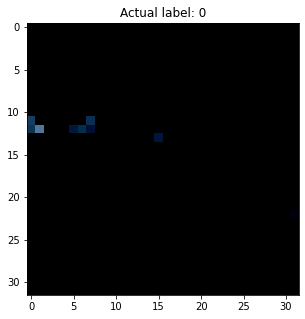

Predicted: negatives, Actual: negatives


In [12]:
# model.load_state_dict(torch.load('binary_classifier_model.pth'))
model.eval()
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
idx = np.random.randint(images.shape[0])  # random choose one index
img, label = images[idx].to(device), labels[idx].to(device)  # move images and labels to the same device

# Image validation
img_cpu = img.to('cpu')
img_np = img_cpu.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  # Convert image from CHW to HWC
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(8, 5))
plt.imshow(img_np)
plt.title(f'Actual label: {label}')
plt.show()

# Predict the image
with torch.no_grad():
    img = img.unsqueeze(0)
    outputs = model(img)
    pred_prob = torch.squeeze(outputs)
    # If the probability is biggerer than or equal to 0.5, the prediction is category 1, otherwise it is category 0
    predicted_labels = (pred_prob >= 0.5).long()
classes = ('negatives','positives')
print(f'Predicted: {classes[predicted_labels]}, Actual: {classes[label]}')

## Advance Solution : Train a DNN based object detector
Depending on your desired apporach, you may want to create a suitable dataset using both the training patches you have been given and the 3D point cloud dataset. These can then be used to train our desired object detector to detect the target in the image. Several object detection frameworks are talked about both in the lectures and labs. 

In [14]:
# Train a classification model to perform binary classification of the patch into whether it contains a sphere or not.

# # Redefine the ball position, get the images and then restore it to its original location manually

# sphere_diameter = 0.12
# sphere_positions = np.asarray([    [-9.2798,2.0016,15.7877],  
#                                    [-9.2798,2.0016,12.9877],   
#                                    [-9.2798,2.0016,10.1877],   
#                                    [-9.2798,2.0016,7.3877],
#                                    [-9.2798,2.0016,4.5877],
#                                    [-9.2798,2.0016,1.7877],
#                                    [-9.2798,2.0016,-1.0123],
#                                    [-9.2798,2.0016,-3.8123]])
# images = []
# annotations = []
# image_size = [160, 240]

# # Camera configuration
# cam = 300
# camera_configs = [
#     (np.array([[1, 0, 0], [2, 0, 0]]), np.array([0, -np.pi/2, 0])),
#     (np.array([[-1, 0, 0], [-2, 0, 0]]), np.array([0, np.pi/2, 0])),
#     (np.array([[0, 0, -1], [0, 0, -2]]), np.array([0, 0, 0])),
#     (np.array([[0, 0, 1], [0, 0, 2]]), np.array([0, 0, np.pi])),
#     (np.array([[0, 1, 0], [0, 2, 0]]), np.array([0, 0, np.pi/2])),
#     (np.array([[0, -1, 0], [0, -2, 0]]), np.array([0, 0, -np.pi/2]))
# ]

# # Capturing pictures from 3D point clouds
# for sphere_center in sphere_positions:
#     for start_end, angle in camera_configs:
#         for position in np.linspace(start_end[0],start_end[1],4):
#             final_position = sphere_center+position
#             image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, final_position)
#             center_x, center_y = image_size[1]//2,image_size[0]//2
#             radius_pixels = int(sphere_diameter * cam / depth[center_y, center_x])
#             bbox = [center_x-radius_pixels,center_y-radius_pixels,center_x+radius_pixels,center_y+radius_pixels]
#             images.append(image)
#             annotations.append({'bbox':bbox,'label':'sphere'})

# save_folder = 'captured_images'
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
# image_filenames = []
# annotations_list = []

# # Save captured images
# for i, (image, annotation) in enumerate(zip(images, annotations)):
#     if image.dtype == np.float64:  # Checking if the image is in float64 format
#         image = np.clip(image, 0, 1)
#         image = (image * 255).astype(np.uint8)
#     image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#     image_filename = f'captured_sphere_{i}.png'
#     annotation['image_filename'] = image_filename
#     annotations_list.append(annotation)
#     cv2.imwrite(os.path.join(save_folder, f'bbox_{image_filename}'), image_bgr)

# # Save all annotations to a single JSON file
# annotations_filename = 'annotations.json'
# with open(os.path.join(save_folder, annotations_filename), 'w') as f:
#     json.dump(annotations_list, f, indent=4)

In [3]:
class SphereDataset(Dataset):
    def __init__(self, root, img_list=None, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(os.path.join(root, "annotations.json")) as f:
            self.annotations = json.load(f)
        if img_list is not None:
            self.imgs = img_list
        else:
            self.imgs = [anno['image_filename'] for anno in self.annotations if anno['image_filename'].lower().endswith('.png')]

    def __getitem__(self, idx):
        # Get the image file name and load the image
        img_filename = self.imgs[idx]
        img_path = os.path.join(self.root, "captured_images", img_filename)
        if not os.path.exists(img_path):  # Check if file exists
            raise FileNotFoundError(f"The file {img_path} does not exist!")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)  # Convert PIL Image to numpy array for albumentations
        # Get the corresponding annotation information
        annotation = self.annotations[idx]
        boxes = np.array([annotation['bbox']], dtype=np.float32)
        label = 1 if annotation['label'] == 'sphere' else 0
        labels = [label]
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        target['iscrowd'] = torch.zeros((1,), dtype=torch.int64)

        if self.transforms:
            sample = {'image': img,'bboxes': target['boxes'],'labels': labels}
            sample = self.transforms(**sample)
            img = sample['image']
            target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(sample['labels'], dtype=torch.int64)
        return img, target
    def __len__(self):
        return len(self.imgs)

In [4]:
def get_train_transform():
    return A.Compose([
        A.Resize(160, 240),
        A.HorizontalFlip(0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transform():
    return A.Compose([
        A.Resize(160,240),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

folder_path = './annotated_images/captured_images'

# Traverse folders, including only .png files
all_img_filenames = [f for f in os.listdir(folder_path) 
                     if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith('.png')]

# Manually divide the file name list
split_point = int(0.8 * len(all_img_filenames))
train_filenames = all_img_filenames[:split_point]
valid_filenames = all_img_filenames[split_point:]

# Create a SphereDataset instance for each subset and apply the transformation
train_dataset = SphereDataset(root='./annotated_images', img_list=train_filenames, transforms=get_train_transform())
valid_dataset = SphereDataset(root='./annotated_images', img_list=valid_filenames, transforms=get_valid_transform())

# Create a DataLoader for each dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
test_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 2 # sphere or background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model.to(device)
num_epochs = 3
itr = 1
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
total_train_loss = []
total_valid_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    # Train the model
    model.train()
    train_loss = []
    pbar = tqdm(train_dataloader, desc='Training')
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v[i].to(device) for k, v in targets.items()} for i in range(len(images))]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {losses.item()}")
    total_train_loss.append(np.mean(train_loss))
    # Update learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    # Test the model
    valid_loss = []
    with torch.no_grad():
        for images, targets in tqdm(test_dataloader, desc='Validation'):
            images = list(img.to(device) for img in images)
            targets = [{k: v[i].to(device) for k, v in targets.items()} for i in range(len(images))]
            loss_dict = model(images, targets)
            valid_loss.append(sum(loss for loss in loss_dict.values()).item())
    total_valid_loss.append(np.mean(valid_loss))
    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time() - start_time}, "
          f"Train Loss: {total_train_loss[-1]}, Valid Loss: {total_valid_loss[-1]}")

# Save trained model
torch.save(model.state_dict(), 'fasterrcnn_model.pth')
print("Saved PyTorch Model State to fasterrcnn_model.pth")

Using cuda device


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Epoch Completed: 1/3, Time: 30.032830238342285, Train Loss: 0.20564775849724637, Valid Loss: 0.0949393962820371


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Epoch Completed: 2/3, Time: 29.935078859329224, Train Loss: 0.0915066815655807, Valid Loss: 0.08654937495787939


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Epoch Completed: 3/3, Time: 29.935338258743286, Train Loss: 0.08205868817608931, Valid Loss: 0.0893632580836614
Saved PyTorch Model State to fasterrcnn_model.pth


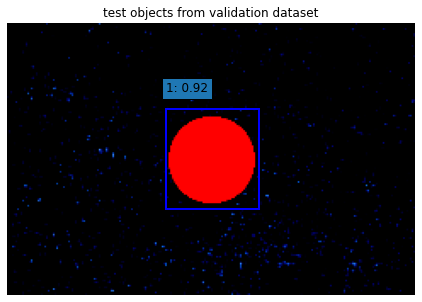

In [10]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
# num_classes = 2
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model.load_state_dict(torch.load('fasterrcnn_model.pth'))
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
image = images[0]  # Obtain one image
image_np = image.numpy()  # transfer Tensor to NumPy array
image_np = np.transpose(image_np, (1, 2, 0))
if image_np.dtype == np.float32 or image_np.dtype == np.float64:
    image_np = np.clip(image_np, 0, 1)
model.eval()
with torch.no_grad():
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
boxes = outputs[0]['boxes']
scores = outputs[0]['scores']
labels = outputs[0]['labels']
# Apply NMS
nms_indices = nms(boxes, scores, iou_threshold=0.3)
# Filter the boxes, scores and labels
filtered_boxes = boxes[nms_indices]
filtered_scores = scores[nms_indices]
filtered_labels = labels[nms_indices]
# Draw boundary boxes
plt.figure(figsize=(8, 5))
plt.imshow(image_np)
plt.title('test objects from validation dataset')
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    plt.gca().add_patch(plt.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], 
                                      edgecolor='b', facecolor='none', linewidth=2))
    plt.gca().text(start_point[0], start_point[1] - 10, f'{label.item()}: {score.item():.2f}',
                   bbox=dict(), fontsize=12)
plt.axis('off')  # Close axis
plt.show()

## Initialise our starting point in the game and get our first view into the scene
We should start the game at a position of XYZ = [0, 0, 0] and a camera angle of [0, 0, 0]. We can then get our first image projected to the camera plane to start our game. 

[{'boxes': tensor([[ 70.2044,  64.5141, 115.0407, 112.4165],
        [ 78.0191,  70.8015, 106.7817, 105.3635],
        [ 58.2498,  55.7331, 128.8009, 127.6180]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7590, 0.4386, 0.2805], device='cuda:0')}]


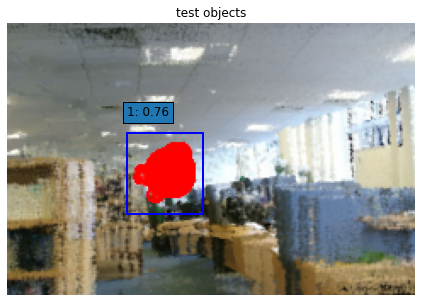

Center of the box in world coordinates: -0.20399082933766824 0.06090859985198152 2.3091081412857477


In [16]:
# Initialise position and angle variable 
position = np.zeros([3])
angle = np.zeros([3])

image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
image_tensor = torch.from_numpy(image).float()
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
with torch.no_grad():
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor)
print(outputs)
boxes = outputs[0]['boxes']
scores = outputs[0]['scores']
labels = outputs[0]['labels']

nms_indices = nms(boxes, scores, iou_threshold=0.2)
filtered_boxes = boxes[nms_indices]
filtered_scores = scores[nms_indices]
filtered_labels = labels[nms_indices]
plt.figure(figsize=(8, 5))
plt.imshow(image)
plt.title('test objects')

for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    plt.gca().add_patch(plt.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], 
                                      edgecolor='b', facecolor='none', linewidth=2))
    plt.gca().text(start_point[0], start_point[1]-10, f'{label.item()}:{score.item():.2f}',
                   bbox=dict(), fontsize=12)
plt.axis('off')
plt.show()

# Obtain the first boundary box
bbox = boxes[0]

# Calculate coordinates of the center of the bounding box
x_center = (bbox[0]+bbox[2])/2
y_center = (bbox[1]+bbox[3])/2

# Obtain the coordinates corresponding to X, Y, Z in the world coordinate system
world_x = map1[int(y_center),int(x_center)]
world_y = map2[int(y_center),int(x_center)]
world_z = map3[int(y_center),int(x_center)]
print("Center of the box in world coordinates:", world_x,world_y,world_z)

Text(0.5, 1.0, 'Map4 Image')

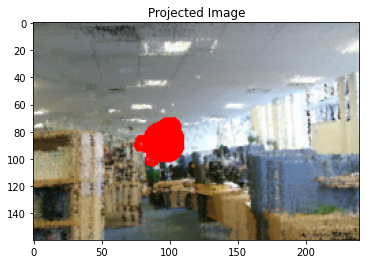

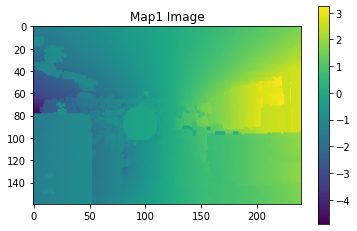

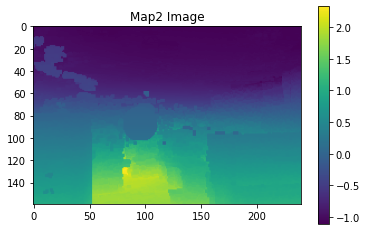

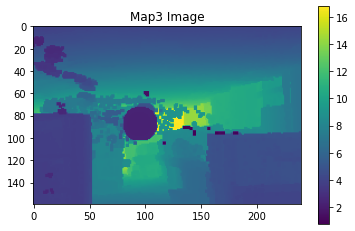

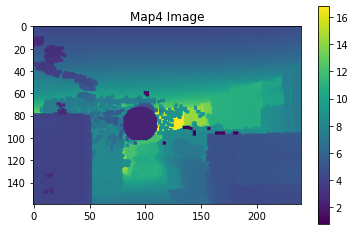

In [17]:
# Get the image, XYZ maps and depth map of the current viewpoint into the scene
plt.figure()
plt.imshow(image)
plt.title('Projected Image')

plt.figure()
plt.imshow(map1)
plt.colorbar()
plt.title('Map1 Image')

plt.figure()
plt.imshow(map2)
plt.colorbar()
plt.title('Map2 Image')

plt.figure()
plt.imshow(map3)
plt.colorbar()
plt.title('Map3 Image')

plt.figure()
plt.imshow(map4)
plt.colorbar()
plt.title('Map4 Image')

## Perform a detection-navigation loop to collect all objects.
This will be the main bulk of your implementation, utilising the trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene, and use the trained model to detect the sphere
-  Collect the sphere by moving towards it. If you land close enough to the object it will be automatically captured and removed from the scene. 


In [18]:
while not np.all(spheres_collected):  # While there are spheres to find
    image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.permute(0, 3, 1, 2)
    
    # Use the trained model to detect the red ball in image
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        if len(outputs[0]['boxes']) == 0:
            # If no red ball is detected, adjust the angle and try different viewing angles
            angle += np.array([0, -np.pi/4,0])
            continue  # Skip this cycle and continue with the next cycle
        bbox = outputs[0]['boxes'][0]

    # Calculate the coordinates of the center of the bounding box
    x_center = (bbox[0]+bbox[2])/2
    y_center = (bbox[1]+bbox[3])/2
    world_x = map1[int(y_center),int(x_center)]
    world_y = map2[int(y_center),int(x_center)]
    world_z = map3[int(y_center),int(x_center)]
    
    # Move position and update scene, this results in a sphere being 'captured'
    position = np.asarray([world_x,world_y,world_z])
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected)
    print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected),len(spheres_collected)))

I am now at position [-0.20399082933766824, 0.06090859985198152, 2.3091081412857477]
I have found 1 out of 11 spheres!

I am now at position [-0.31827847714408203, -0.03381336695222034, 4.673412236115336]
I have found 2 out of 11 spheres!

I am now at position [-0.9211396714313979, 0.19850687239066173, 7.011826953504689]
I have found 3 out of 11 spheres!

I am now at position [-1.0389913644214048, 0.6202065451988316, 9.378556972141258]
I have found 4 out of 11 spheres!

I am now at position [-1.8852075485915767, 0.7721780374796396, 12.179000776133519]
I have found 5 out of 11 spheres!

I am now at position [-3.720986064976825, 1.0842206744232552, 13.007617677303095]
I have found 6 out of 11 spheres!

I am now at position [-6.556504850800904, 1.4556170141074358, 13.226182322696905]
I have found 7 out of 11 spheres!

I am now at position [-8.899008161298088, 1.659840530579262, 11.532809472476941]
I have found 8 out of 11 spheres!

I am now at position [-9.37181818784589, 1.80962077855049

References<br>
https://www.kaggle.com/code/dangnam739/faster-rcnn-global-wheat-detection